# Large Scale Processing

<div>
    <img style='width: 220px;height: 100px;float: left;' src="./Supplementary_data/EODC-Logo-Final.png" height='100px' width='220px'/>
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/BMNT_DE_Logo_dreizeilig_srgb.svg" height='100px' width='200px'/> 
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/bmlv.svg" height='100px' width='200px'/>
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/LOGO_TUW_GEO.png" height='100px' width='200px'/>
    <img style='width: 100px;height: 100px;float: left;' src="./Supplementary_data/Boku-wien.svg" height='100px' width='100px'/>
    <img style='width: 150px;height: 100px;float: right;' src="./Supplementary_data/ADC_Logo_final_transparent.png" height='100px' width='150px'/>
</div>

This notebook outlines working with `GridWorkflow` for continental and large scale analysis and processing. Since there are limits in what the current computing capabilities, especially in processor and memory usage, it is important to split large data cubes (continental, multiple countries etc.) into a grid and process/analyse each cell of the grid independently.

## Initial and GridWorkflow setup

The first step is to import the necessary dependencies.

In [1]:
import datacube
import numpy
%matplotlib inline

The next steps are:

1. Initiate the connection to the datacube and storing it into the variable `dc`

2. Setup the processing Grid with GridSpec and store it in the variable `gs`

3. Initialize the GridWorkflow and store it in variable `gwf`

In [2]:
dc = datacube.Datacube(app='sample_6', env='acube')

Parameters for the `GridSpec` are:
    
1. `crs` - Coordinate reference frame of the grid

2. `tile_size` - Size of the tiles in crs units

3. `resolution` - Resolution of the resampling

4. `origin` - Optional parameter for the origin of the (0, 0) tile

In [3]:
gs = datacube.model.GridSpec(crs=datacube.model.geometry.CRS('EPSG:3857'),
                             tile_size=(10000, 10000),
                             resolution=(-10, 10))

This gives us 1000x1000 pixel tiles

In [4]:
gs.tile_resolution

(1000, 1000)

Parameters for the `GridWorkflow` are:

1. `index` - The index of the datacube in `dc.index`

2. `product` - Desired product

3. `grid_spec` - The `GridSpec` stored in `gs`

In [5]:
gwf = datacube.api.GridWorkflow(dc.index, product='GMR_Sentinel_1', grid_spec=gs)

## Building the query

By specyfing desired spatial and temporal bounds we can list the cells indexes for any given product that contain data

In [8]:
qdict = {
    'latitude': (47.5, 48),
    'longitude': (16.5, 17),
    'time': ('2017-05-01', '2017-06-01'),
}
cells = gwf.list_cells(product_type='TUW_GMR_S1', product='GMR_Sentinel_1', **qdict)
cells.keys()

dict_keys([(187, 602), (188, 602), (189, 602), (187, 603), (188, 603), (189, 603), (187, 604), (188, 604), (189, 604), (187, 605), (188, 605), (189, 605), (187, 606), (188, 606), (189, 606), (187, 607), (188, 607), (189, 607), (187, 608), (188, 608), (189, 608), (187, 609), (188, 609), (189, 609), (186, 610), (187, 610), (188, 610), (189, 610), (183, 602), (184, 602), (185, 602), (186, 602), (183, 603), (184, 603), (185, 603), (186, 603), (183, 604), (184, 604), (185, 604), (186, 604), (183, 605), (184, 605), (185, 605), (186, 605), (183, 606), (184, 606), (185, 606), (186, 606), (183, 607), (184, 607), (185, 607), (186, 607), (183, 608), (184, 608), (185, 608), (186, 608), (183, 609), (184, 609), (185, 609), (186, 609), (183, 610), (184, 610), (185, 610)])

Here, a random cell is drawn from the list and it is possible to preview some information about it such as dimensions, GeoBox and shape which contains how many temporal slices it contains. It is possible to iterate over cells in parallel lazy load them and perform analysis and computation. We can see that there are 48 time slices.

In [9]:
test_cell = cells[(186, 610)]
print(test_cell.dims)
print(test_cell.product)
print(test_cell.shape)
print(test_cell.geobox)

('time', 'y', 'x')
DatasetType(name='GMR_Sentinel_1', id_=18)
(34, 1000, 1000)
GeoBox(Geometry({'type': 'Polygon', 'coordinates': (((16.708664284623097, 48.01890181696988), (16.708664284623097, 47.958779800526045), (16.79849581303505, 47.958779800526045), (16.79849581303505, 48.01890181696988), (16.708664284623097, 48.01890181696988)),)}, CRS('EPSG:4326')))


Finally the data of the cell (**Not the entire product**) is loaded and stored in the `data` variable. The idea is that working with smaller cells uses less resources instead of loading a resource hungry datacube object that the machine cannot handle.

In [10]:
data = gwf.load(test_cell)

## Analasys

By listing the information from `Dataset` a couple of things may be noticed:

1. There are 48 temporal slices in a 1000x1000 pixel tile defined by the `GridSpec`

2. Which datatype is the data

3. The Data Variables of the product, in this case these are the polarisations `VV` and `VH`

4. Attributes of the `Dataset`

In [11]:
data

<xarray.Dataset>
Dimensions:      (time: 34, x: 1000, y: 1000)
Coordinates:
  * time         (time) datetime64[ns] 2017-05-01T05:01:08.500000 ... 2017-06...
  * y            (y) float64 6.11e+06 6.11e+06 6.11e+06 ... 6.1e+06 6.1e+06
  * x            (x) float64 1.86e+06 1.86e+06 1.86e+06 ... 1.87e+06 1.87e+06
    spatial_ref  int32 3857
Data variables:
    VV           (time, y, x) int16 -1663 -1548 -1548 ... -9999 -9999 -9999
    VH           (time, y, x) int16 -2623 -2928 -2928 ... -9999 -9999 -9999
Attributes:
    crs:           EPSG:3857
    grid_mapping:  spatial_ref

The dataset can be converted into a `DataArray` by selecting a specific data variable. Meanwhile we can drop the nodata values along the time axis. Here we select the `VV` polarisation. We can also notice more attributes such as:

1. Units of the data

2. Nodata Value

3. CRS of the selection

In [12]:
VV_polarisation = data.VV.where(data.VV != data.VV.attrs['nodata']).dropna(dim='time')
VV_polarisation

<xarray.DataArray 'VV' (time: 10, y: 1000, x: 1000)>
array([[[-1663., -1548., -1548., ...,  -479.,  -479.,  -763.],
        [-1550., -1390., -1390., ...,  -627.,  -627.,  -980.],
        [-1550., -1475., -1475., ...,  -627.,  -821., -1125.],
        ...,
        [ -818.,  -780.,  -842., ..., -1552., -1552., -1515.],
        [ -877.,  -871., -1069., ..., -1514., -1514., -1538.],
        [ -877., -1092., -1092., ..., -1435., -1435., -1609.]],

       [[ -566.,  -858.,  -858., ...,  -552.,  -552.,  -500.],
        [ -792., -1011., -1011., ...,  -393.,  -393.,  -323.],
        [ -792.,  -889.,  -889., ...,  -393.,  -392.,  -299.],
        ...,
        [ -725.,  -673., -1169., ..., -1153., -1153., -1194.],
        [ -724.,  -654.,  -862., ..., -1280., -1280., -1227.],
        [ -724.,  -756.,  -756., ..., -1280., -1280., -1232.]],

       [[-1529., -1400., -1400., ...,  -951.,  -951.,  -910.],
        [-1479., -1331., -1331., ...,  -900.,  -900.,  -393.],
        [-1479., -1491., -1491., ...,  -900.,  -854.,  -249.],
        ...,
...
        ...,
        [-1002., -1021.,  -699., ..., -1024., -1024., -1005.],
        [ -901.,  -853.,  -651., ...,  -888.,  -888.,  -885.],
        [ -901.,  -795.,  -795., ...,  -994.,  -994.,  -983.]],

       [[-1199., -1197., -1197., ...,  -752.,  -752.,  -714.],
        [-1139.,  -942.,  -942., ...,  -946.,  -946.,  -806.],
        [-1139.,  -564.,  -564., ...,  -946.,  -808.,  -784.],
        ...,
        [ -757.,  -704.,  -792., ..., -1306., -1306., -1390.],
        [ -725.,  -723.,  -848., ..., -1200., -1200., -1284.],
        [ -725.,  -765.,  -765., ..., -1202., -1202., -1118.]],

       [[-1404., -1401., -1401., ...,  -986.,  -986.,  -982.],
        [-1358., -1455., -1455., ...,  -863.,  -863.,  -960.],
        [-1358., -1536., -1536., ...,  -863.,  -877., -1051.],
        ...,
        [ -670.,  -581.,  -535., ..., -1259., -1259., -1364.],
        [ -815.,  -780.,  -754., ..., -1201., -1201., -1398.],
        [ -815.,  -894.,  -894., ..., -1187., -1187., -1399.]]])
Coordinates:
  * time         (time) datetime64[ns] 2017-05-01T05:01:08.500000 ... 2017-05...
  * y            (y) float64 6.11e+06 6.11e+06 6.11e+06 ... 6.1e+06 6.1e+06
  * x            (x) float64 1.86e+06 1.86e+06 1.86e+06 ... 1.87e+06 1.87e+06
    spatial_ref  int32 3857
Attributes:
    units:         dB
    nodata:        -9999
    crs:           EPSG:3857
    grid_mapping:  spatial_ref

The `plot.imshow()` method displays the data. We can use arguments of the library `matplotlib` to change the display of the image. Tutorials on `matplotlib` can be found at https://matplotlib.org/tutorials/index.html

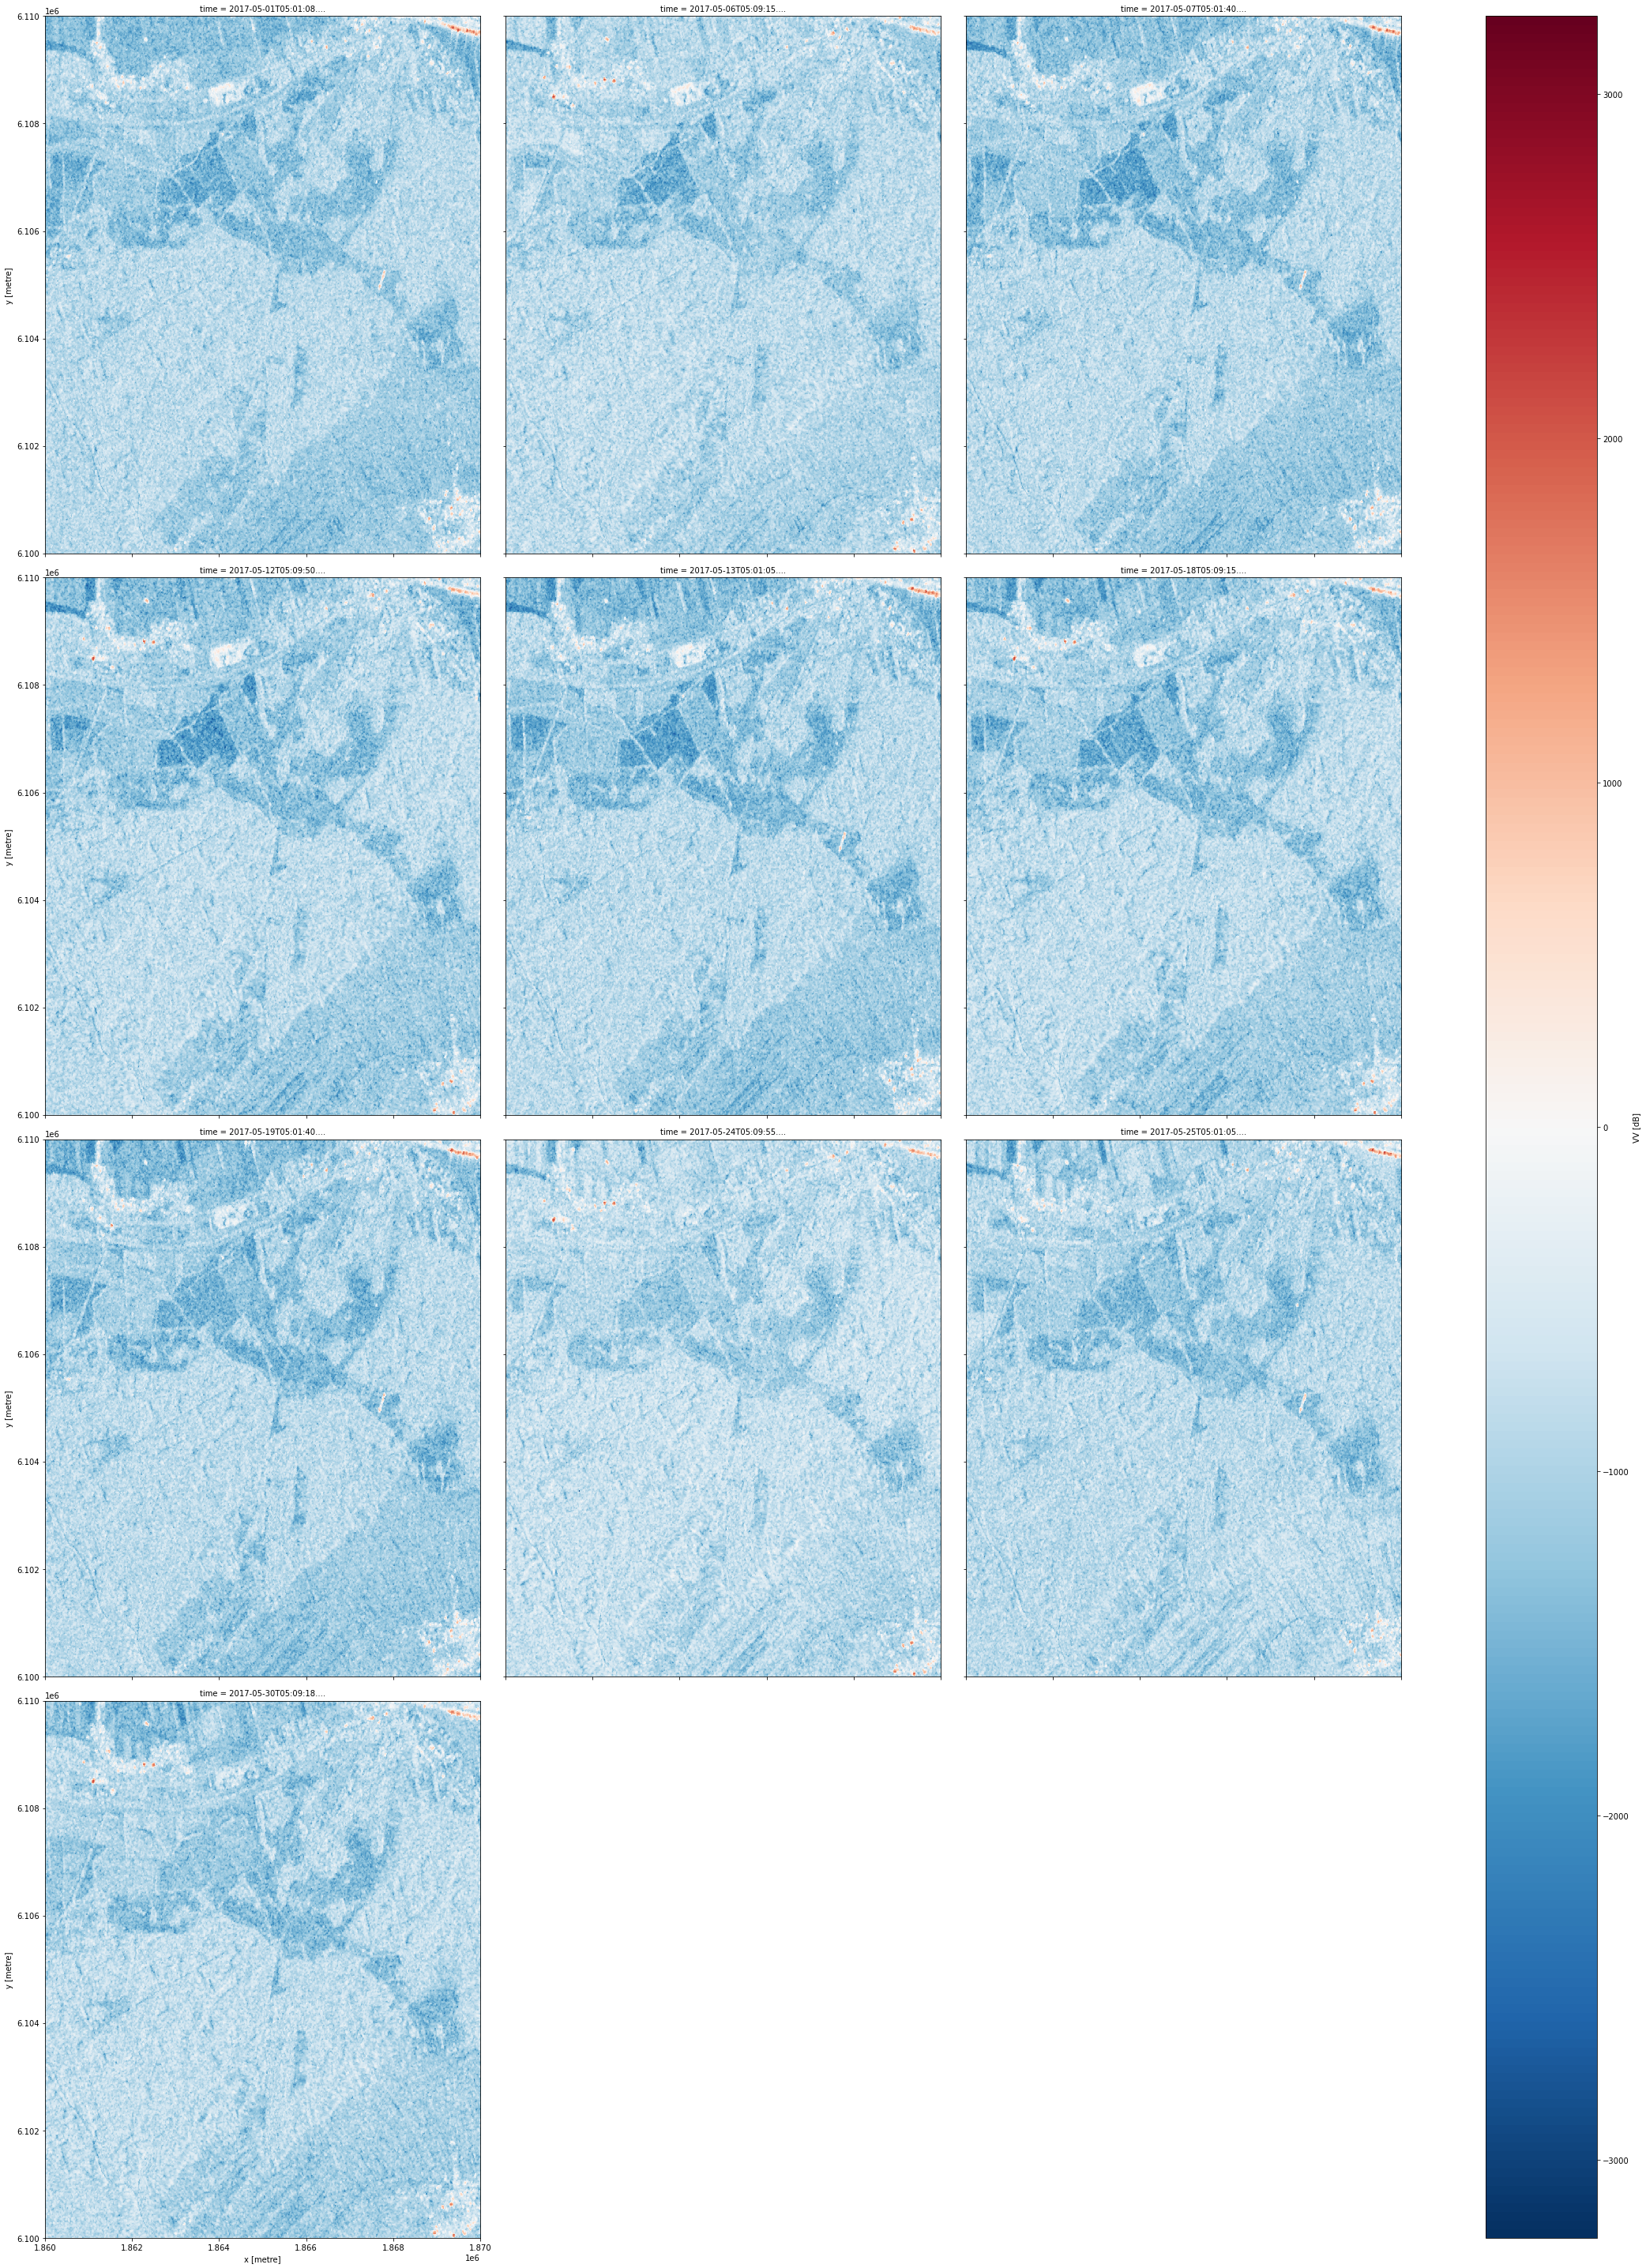

In [13]:
VV_polarisation.plot.imshow(x='x', 
                            y='y',
                            col='time',
                            size=10,
                            col_wrap=3,
                            add_colorbar=True)

Using the `plot()` function we can preview a histogram for the given area.

(array([5.800000e+01, 5.095000e+03, 3.243430e+05, 3.640238e+06,
        5.610538e+06, 3.892400e+05, 2.148600e+04, 6.566000e+03,
        2.021000e+03, 4.150000e+02]),
 array([-3227. , -2681.7, -2136.4, -1591.1, -1045.8,  -500.5,    44.8,
          590.1,  1135.4,  1680.7,  2226. ]),
 <BarContainer object of 10 artists>)

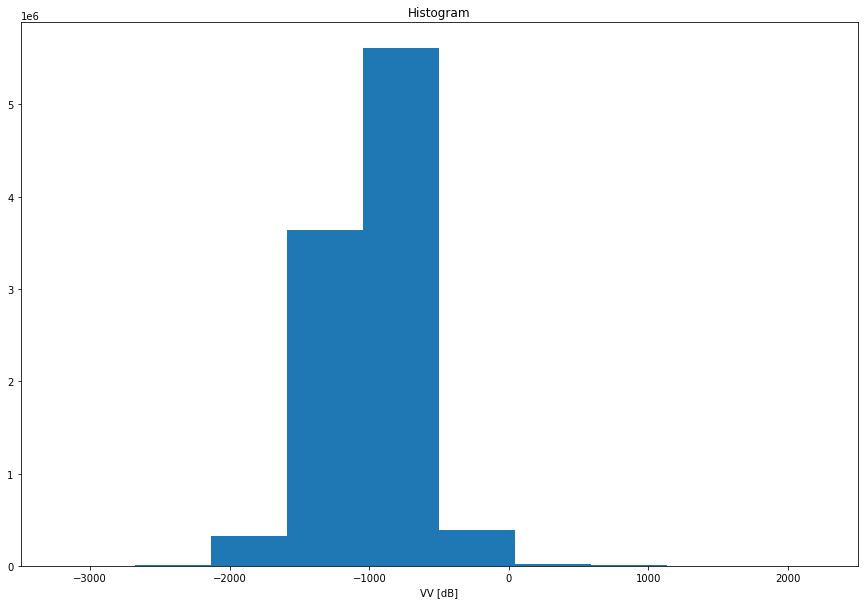

In [14]:
VV_polarisation.plot(size=10)

By using the `sel()` function we can select a specific nearest pixel to our desired coordinates and do a temporal drill to preview the values of the data.

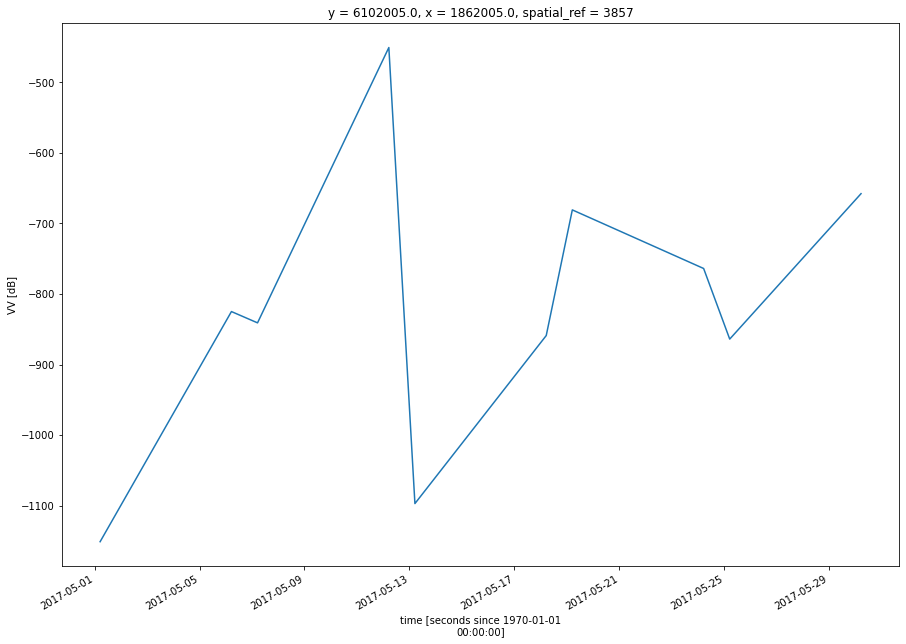

In [15]:
selection = VV_polarisation.sel(y=6102000, x=1862000, method='nearest')
selection.plot(size=10)